<a href="https://colab.research.google.com/github/crystalmford/copilot-llm-finetuning/blob/main/copilot_llm_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copilot Tuning Demo: Support Ticket Assistant
Crystal Ford — Sept 2025

*This notebook was created to demonstrate my abilities for the Applied Scientist II – Copilot Tuning position (Job #1856259, Microsoft M365 Copilot Team).*

This notebook demonstrates how to **fine-tune a small LLM (FLAN-T5-small) with LoRA adapters**, add a **retrieval-augmented generation (RAG) step**, and apply a **simple reward function for alignment-style scoring**.  

This is a lightweight proof-of-concept for Copilot-style tuning:
1. Fine-tuning FLAN-T5 on a tiny support ticket dataset.
2. Adding RAG over a mini knowledge base (FAQs, policies).
3. Using a simple reward function to prefer safe, concise, grounded answers.

# Copilot Tuning Demo: Support Ticket Assistant

**Note:** This demo does not require any API keys.  
All models are open-source Hugging Face models and training runs locally in Colab.  
Everything here is self-contained and reproducible without credentials.

## Setup
Install Hugging Face, PEFT (for LoRA), and FAISS (for retrieval).  
These are the core tools for fine-tuning and retrieval augmentation.


In [23]:
!pip install -q transformers accelerate peft bitsandbytes datasets sentence-transformers faiss-cpu pandas scikit-learn


## Load Support Ticket Dataset
This is a small toy dataset of support tickets and expected answers.  
The dataset is intentionally small to keep training light and demonstrate the pipeline quickly.


In [24]:
import pandas as pd
from datasets import Dataset

data = {
    "ticket_id": [1, 2, 3],
    "body": [
        "My widget arrived cracked. What is the refund policy?",
        "I can't log in after too many attempts.",
        "How long is the warranty on accessories?"
    ],
    "expected_answer": [
        "You can request a replacement or refund within 30 days. Provide your order number.",
        "Wait 15 minutes or reset via email link; support can manually unlock if needed.",
        "Accessories carry a 6-month limited warranty per policy."
    ]
}
df = pd.DataFrame(data)
dataset = Dataset.from_pandas(df)
df

,ticket_id,body,expected_answer
0,1,My widget arrived cracked. What is the refund ...,You can request a replacement or refund within...
1,2,I can't log in after too many attempts.,Wait 15 minutes or reset via email link; suppo...
2,3,How long is the warranty on accessories?,Accessories carry a 6-month limited warranty p...


## Load Model and Tokenizer
FLAN-T5-small is used because it supports instruction fine-tuning and can run quickly in Colab.  
The model is loaded in 8-bit mode to reduce memory usage.

In [25]:
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_name = "google/flan-t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(
    model_name,
    device_map="auto",
    load_in_8bit=True
)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


## Add LoRA Adapters
LoRA adapters make it possible to fine-tune large models efficiently by training only a small number of additional parameters.  
This approach is well-suited for quick experiments and limited compute.

In [26]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q", "v"],  # attention weights
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ_2_SEQ_LM"
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 344,064 || all params: 77,305,216 || trainable%: 0.4451


## Tokenize Data for Fine-Tuning
Inputs (ticket bodies) and labels (expected answers) are tokenized.  
Transformers require token IDs and labels for sequence-to-sequence tasks.

In [27]:
def preprocess(batch):
    model_inputs = tokenizer(batch["body"], max_length=128, truncation=True)
    labels = tokenizer(batch["expected_answer"], max_length=128, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized = dataset.map(preprocess, batched=True)

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

## Fine-Tune the Model
Train for two epochs on the small dataset to show LoRA updates in action.  
The run is short but demonstrates the fine-tuning process.  

**Note:** This section does not require any API keys.  
The training uses an open Hugging Face model (FLAN-T5) that runs entirely in Colab.

In [28]:
from transformers import DataCollatorForSeq2Seq, TrainingArguments, Trainer
from tqdm.auto import tqdm

collator = DataCollatorForSeq2Seq(tokenizer, model=model)

args = TrainingArguments(
    per_device_train_batch_size=2,
    num_train_epochs=2,
    learning_rate=5e-4,
    output_dir="./outputs",
    logging_steps=1,
    save_strategy="no",
    report_to="none"  # turn off wandb/hf logs
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized,
    data_collator=collator
)

from tqdm.auto import tqdm

num_epochs = 2
steps_per_epoch = len(tokenized) // 2  # batch size=2

print("Starting training...")
for epoch in tqdm(range(num_epochs), desc="Epochs", colour="magenta"):
    progress_bar = tqdm(range(steps_per_epoch), desc=f"Epoch {epoch+1}", colour="pink")
    trainer.train()
    progress_bar.update(steps_per_epoch)
    progress_bar.close()

Starting training...


Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,3.728500
2,5.738300
3,4.546900
4,4.964800


Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s]

Step,Training Loss
1,4.082000
2,5.796900
3,4.453100
4,4.531200


In [29]:
trainer.train()

Step,Training Loss
1,3.832000
2,5.546900
3,4.394500
4,4.808600


TrainOutput(global_step=4, training_loss=4.6455078125, metrics={'train_runtime': 27.2515, 'train_samples_per_second': 0.22, 'train_steps_per_second': 0.147, 'total_flos': 25194092544.0, 'train_loss': 4.6455078125, 'epoch': 2.0})

## Training Loss Curve
Plot the loss across training steps to confirm the model is learning during fine-tuning.

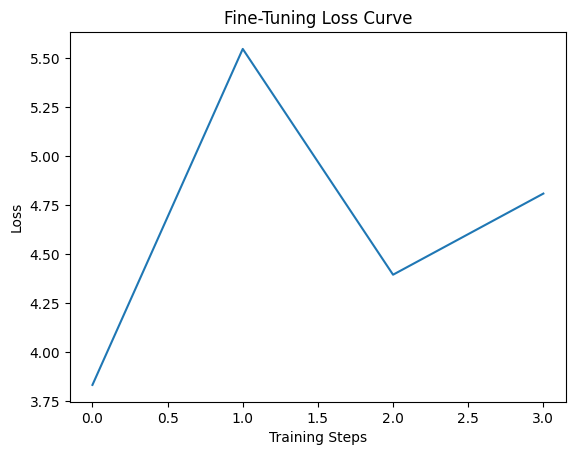

In [30]:
import matplotlib.pyplot as plt

log_history = trainer.state.log_history
losses = [entry["loss"] for entry in log_history if "loss" in entry]

plt.plot(losses)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Fine-Tuning Loss Curve")
plt.show()

## Add Retrieval-Augmented Generation (RAG)
A small knowledge base of FAQ and policy snippets is embedded and indexed using FAISS.  
The model retrieves relevant facts at inference time to improve grounding and accuracy.

In [31]:
from sentence_transformers import SentenceTransformer
import faiss

kb_docs = [
    "Refunds: Items can be returned within 30 days with proof of purchase.",
    "Login policy: After 3 failed attempts, wait 15 minutes or reset via email.",
    "Warranty: Accessories are covered for 6 months."
]

kb_model = SentenceTransformer("all-MiniLM-L6-v2")
kb_embeddings = kb_model.encode(kb_docs)

index = faiss.IndexFlatL2(kb_embeddings.shape[1])
index.add(kb_embeddings)

## Generate with RAG and Simple Reward Function
The pipeline retrieves context, generates multiple candidate answers, and scores them.  
The reward function prefers answers that are polite, concise, and grounded in retrieved facts.

In [32]:
import numpy as np

def retrieve_context(query, top_k=1):
    q_emb = kb_model.encode([query])
    D, I = index.search(np.array(q_emb), top_k)
    return [kb_docs[i] for i in I[0]]

def reward_function(answer, context):
    score = 0
    if any(term.lower() in answer.lower() for term in ["sorry","thank","please"]):
        score += 1
    if len(answer.split()) <= 40:
        score += 1
    if any(c.lower() in answer.lower() for c in context):
        score += 2
    return score

def generate_with_rag(query):
    context = retrieve_context(query)
    prompt = f"Context: {context}\n\nQuestion: {query}\nAnswer:"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    candidates = []
    for _ in range(3):
        output = model.generate(**inputs, max_length=80, do_sample=True, top_p=0.9)
        text = tokenizer.decode(output[0], skip_special_tokens=True)
        candidates.append((text, reward_function(text, context)))
    best = max(candidates, key=lambda x: x[1])
    return best

print(generate_with_rag("My widget arrived cracked. What is the refund policy?"))

('Validation of any item is subject to verification.', 1)


## Reward Function Comparison
Show multiple candidate answers with their reward scores to demonstrate how the alignment-like scoring works.

In [33]:
query = "My widget arrived cracked. What is the refund policy?"
context = retrieve_context(query)
prompt = f"Context: {context}\n\nQuestion: {query}\nAnswer:"
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

for i in range(3):
    output = model.generate(**inputs, max_length=80, do_sample=True, top_p=0.9)
    text = tokenizer.decode(output[0], skip_special_tokens=True)
    print(f"Candidate {i+1}:", text)
    print("Reward Score:", reward_function(text, context))
    print("---")

Candidate 1: ['Respatch: Items can be returned within 30 days with proof of purchase.']
Reward Score: 1
---
Candidate 2: refunds: Items can be returned within 30 days with proof of purchase.
Reward Score: 3
---
Candidate 3: No problem with the device.
Reward Score: 1
---


## Next Steps
- Expand the dataset with more synthetic support tickets.  
- Experiment with larger models (LLaMA-2, Mistral) using quantization for efficiency.  
- Replace the reward function with PPO or DPO for proper RLHF.  
- Deploy the pipeline as an API (FastAPI/Flask) for interactive use.